In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import os

from src import preprocessing, config, plotting, utils

# Set up directory structure

In [2]:
# Data directories
os.makedirs(config.DATA_DIR, exist_ok=True)
os.makedirs(config.RAW_DATA_DIR, exist_ok=True)
os.makedirs(config.SHAPEFILES_DIR, exist_ok=True)
os.makedirs(config.INTERIM_DATA_DIR, exist_ok=True)
os.makedirs(config.PROCESSED_DATA_DIR, exist_ok=True)

# Model directory
os.makedirs(config.MODEL_DIR, exist_ok=True)

# Obtain raw data

This step calls functions in `src/preprocessing/` to perform the following:
- Fetch the 2020 Decennial Census Demographic Profile through the Census API
- Fetch select variables from the 2023 American Community Survey (5-Year), defined in `src/config.py`, through the Census API
- Fetch census tracts and area water shapefiles for the NYC area (from 2023)
- Save the resulting raw data to paths defined in `src/config.py` with the variable names `config.*_RAW`

In [6]:
# Get 2020 Decennial Census data
decennial2020_dp_raw = preprocessing.fetch_2020_demographic_profile()

GET request status: 200


In [7]:
# Get 2023 ACS 5yr data
acs5yr2023_raw = preprocessing.fetch_2023_acs_5yr_select()

GET request status: 200


In [ ]:
# Get tract and areawater shapefiles
preprocessing.fetch_shapefiles()

GET request status for tl_2023_36_tract.zip: 200
GET request status for tl_2023_36005_areawater.zip: 200
GET request status for tl_2023_36047_areawater.zip: 200
GET request status for tl_2023_36061_areawater.zip: 200
GET request status for tl_2023_36081_areawater.zip: 200
GET request status for tl_2023_36085_areawater.zip: 200


# Perform initial cleaning

This first cleaning step calls functions in `src/preprocessing/` to perform the following:
- Remove unnecessary columns
- Rename the remaining columns to be human-readable
- Subtract water area from Census tract geometries for more intuitive plotting
- Convert numeric columns to numeric data types (from strings)
- Fill in undefined values as np.nan
- Save the resulting dataframes in `data/interim/` to paths defined in `src/config` with the variable names `config.*_INIT_CLEAN`

In [3]:
# Clean NYC census tract shapefiles
gdf = preprocessing.clean_tracts(config.TRACTS_RAW, config.TRACTS_INIT_CLEAN, config.AREAWATER)

print(f"Number of tracts (that are not entirely water): {np.array(gdf).shape[0]}")
gdf.sample(n=5)

Number of tracts (that are not entirely water): 2324


,BOROUGH,TRACT,AREA,LAT,LONG,geometry
GEOID,,,,,,
36081076902,Queens,769.02,101240,40.715034,-73.834033,"POLYGON ((-73.83673 40.71574, -73.83496 40.717..."
36005031200,The Bronx,312,202061,40.862062,-73.842449,"POLYGON ((-73.84444 40.86279, -73.84437 40.865..."
36047072000,Brooklyn,720,158228,40.628850,-73.920047,"POLYGON ((-73.92401 40.62857, -73.92313 40.629..."
36081044302,Queens,443.02,277970,40.739812,-73.864063,"POLYGON ((-73.86756 40.74168, -73.86724 40.741..."
36081107201,Queens,1072.01,1382812,40.603504,-73.821416,"POLYGON ((-73.8344 40.59646, -73.8342 40.59666..."


In [4]:
decennial2020_dp_initclean = preprocessing.initial_clean_2020_demographic_profile()
print(f"Number of tracts: {np.array(decennial2020_dp_initclean).shape[0]}")
print(f"Number of columns: {np.array(decennial2020_dp_initclean).shape[1]}")
decennial2020_dp_initclean.sample(n=5)

Number of tracts: 2327
Number of columns: 153


,pop,pop_under5,pop_5to9,pop_10to14,pop_15to19,pop_20to24,pop_25to29,pop_30to34,pop_35to39,pop_40to44,pop_45to49,pop_50to54,pop_55to59,pop_60to64,pop_65to69,pop_70to74,pop_75to79,pop_80to84,pop_85plus,pop_16plus,pop_18plus,pop_21plus,pop_62plus,pop_65plus,pop_male,pop_male_under5,pop_male_5to9,pop_male_10to14,pop_male_15to19,pop_male_20to24,pop_male_25to29,pop_male_30to34,pop_male_35to39,pop_male_40to44,pop_male_45to49,pop_male_50to54,pop_male_55to59,pop_male_60to64,pop_male_65to69,pop_male_70to74,pop_male_75to79,pop_male_80to84,pop_male_85plus,pop_male_16plus,pop_male_18plus,pop_male_21plus,pop_male_62plus,pop_male_65plus,pop_female,pop_female_under5,pop_female_5to9,pop_female_10to14,pop_female_15to19,pop_female_20to24,pop_female_25to29,pop_female_30to34,pop_female_35to39,pop_female_40to44,pop_female_45to49,pop_female_50to54,pop_female_55to59,pop_female_60to64,pop_female_65to69,pop_female_70to74,pop_female_75to79,pop_female_80to84,pop_female_85plus,pop_female_16plus,pop_female_18plus,pop_female_21plus,pop_female_62plus,pop_female_65plus,medianage,medianage_male,medianage_female,pop_onerace,pop_white,pop_black,pop_nativeam,pop_asian,pop_hipacific,pop_other,pop_multi,racetally,racetally_white,racetally_black,racetally_nativeam,racetally_asian,racetally_hipacific,racetally_other,pop_hispanic,pop_nonhispanic,pop_hispanic_white,pop_hispanic_black,pop_hispanic_nativeam,pop_hispanic_asian,pop_hispanic_hipacific,pop_hispanic_other,pop_hispanic_multi,pop_nonhisp_white,pop_nonhisp_black,pop_nonhisp_nativeam,pop_nonhisp_asian,pop_nonhisp_hipacific,pop_nonhisp_other,pop_nonhisp_multi,pop_household,pop_household_householder,pop_household_spouse_oppsex,pop_household_spouse_samesex,pop_household_unmpartner_oppsex,pop_household_unmpartner_samesex,pop_household_child,pop_household_child_under18,pop_household_grandchild,pop_household_grandchild_under18,pop_household_otherrelatives,pop_household_nonrelatives,pop_gpquarters,pop_gpquarters_institutionalized,pop_gpquarters_institutionalized_male,pop_gpquarters_institutionalized_female,pop_gpquarters_noninst,pop_gpquarters_noninst_male,pop_gpquarters_noninst_female,households,households_married,households_married_withchild,households_cohabit,households_cohabit_withchild,households_singlemale,households_singlemale_alone,households_singlemale_alone_65plus,households_singlemale_withchild,households_singlefemale,households_singlefemale_alone,households_singlefemale_alone_65plus,households_singlefemale_withchild,households_withunder18,households_with65plus,housing,housing_occupied,housing_vacant,housing_vacant_forrent,housing_vacant_rentedunocc,housing_vacant_forsale,housing_vacant_soldunocc,housing_vacant_seasonal,housing_vacant_other,vacancyrate_homeowner,vacancyrate_rental,housing_owneroccupied,housing_renteroccupied
GEOID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
36005020502,2462,122,159,144,172,177,187,149,140,168,153,175,165,150,120,105,78,62,36,2010,1930,1832,494,401,1099,50,78,70,80,72,87,68,53,74,87,70,73,76,53,43,38,18,9,894,850,804,209,161,1363,72,81,74,92,105,100,81,87,94,66,105,92,74,67,62,40,44,27,1116,1080,1028,285,240,39.2,38.1,39.5,2072,163,866,15,18,4,1006,390,2883,349,1076,63,33,11,1351,1638,824,121,147,11,3,0,992,364,42,719,4,15,4,14,26,2430,952,196,6,63,0,745,402,71,53,269,128,32,13,4,9,19,9,10,948,210,91,60,29,233,157,60,21,445,183,105,98,305,334,990,948,42,22,0,0,0,1,19,0.0,2.6,115,833
36061020000,2855,115,90,116,82,128,292,362,279,211,185,203,222,190,135,95,72,42,36,2512,2493,2424,502,380,1392,61,50,52,44,53,140,178,125,101,92,112,104,105,70,47,32,15,11,1215,1206,1176,246,175,1463,54,40,64,38,75,152,184,154,110,93,91,118,85,65,48,40,27,25,1297,1287,1248,256,205,39.3,39.7,38.9,2520,901,1274,16,171,4,154,335,3232,1123,1455,73,230,5,346,412,2443,42,69,12,0,1,130,158,859,1205,4,171,3,24,177,2706,1381,290,22,97,28,507,313,42,23,123,216,149,0,0,0,149,94,55,1388,319,122,125,16,

In [5]:
# Clean 2023 ACS 5-year data
acs5yr2023_initclean = preprocessing.initial_clean_2023_acs_5yr_select()

print(f"Number of tracts: {np.array(acs5yr2023_initclean).shape[0]}")
print(f"Number of columns: {np.array(acs5yr2023_initclean).shape[1]}")
acs5yr2023_initclean.sample(n=5)

Number of tracts: 2327
Number of columns: 12


,pct_sameresidence1yr,pct_foreignborn,pct_englishonlyhome,pct_commute_transit,pct_commute_walk,medianhouseholdincome,pct_incomebelowpoverty,pct_housing_1unitdetached,pct_housing_1unitattached,pct_housing_20plusunits,medianhomevalue,medianrent
GEOID,,,,,,,,,,,,
36081115100,96.9,51.7,26.4,31.6,2.8,121719.0,4.9,64.8,17.5,0.0,1093200.0,2315.0
36047021400,84.8,35.5,18.4,36.3,23.7,69088.0,28.8,5.6,10.8,5.4,1035300.0,1764.0
36081015700,83.9,48.8,32.4,47.7,9.8,70353.0,9.4,0.0,0.0,63.8,1131600.0,1899.0
36081086900,86.9,75.2,7.2,40.3,27.6,86165.0,15.1,13.3,3.2,57.4,869800.0,1899.0
36047037700,90.8,17.6,87.7,39.1,3.9,66302.0,22.1,0.0,8.8,0.0,1167600.0,2020.0


# Stage 2 cleaning

This stage involves more involved cleaning, divided into subsections below. I save the resulting dataframes in `data/interim/` to paths defined in `src/config` with the variable names `config.*_CLEAN`.

## Remove low population, low household tracts

To reduce noise in fractional values calculated later, remove any tracts with a small number of people or households.

In [24]:
# Load in dataframes
decennial2020_dp_initclean = pd.read_parquet(config.DECENNIAL2020_DP_INIT_CLEAN)
acs5yr2023_initclean = pd.read_parquet(config.ACS5YR2023_INIT_CLEAN)
tracts_initclean = gpd.read_parquet(config.TRACTS_INIT_CLEAN)

In [25]:
# Get rows with population >= 200 and households >= 100
is_highpop = (decennial2020_dp_initclean["pop"] >= 200) & (decennial2020_dp_initclean["households"] >= 100)
rows_highpop = decennial2020_dp_initclean[is_highpop].index
print(is_highpop.describe()) # Only 13/2327 tracts (~0.5%) are excluded

count     2327
unique       2
top       True
freq      2212
dtype: object


In [26]:
decennial2020_dp_clean = decennial2020_dp_initclean.loc[rows_highpop]
acs5yr2023_clean = acs5yr2023_initclean.loc[rows_highpop]
tracts_clean = tracts_initclean.loc[rows_highpop]

# Check that all dataframes have the same number of rows
print(f"decennial2020_dp_clean has shape {decennial2020_dp_clean.shape}")
print(f"acs5yr2023_clean has shape {acs5yr2023_clean.shape}")
print(f"tracts_clean has shape {tracts_clean.shape}")

decennial2020_dp_clean has shape (2212, 153)
acs5yr2023_clean has shape (2212, 12)
tracts_clean has shape (2212, 6)


## Remove NaN from ACS tracts using geographic interpolation

The Decennial Demographic Profile data has no undefined variables, but the ACS data does. Fill in data using a geographic interpolation technique (function defined in `src/utils/`) that computes a value for a tract representing an average of the tract's neighbors with well-defined values, weighted by border length.

The feature `medianhomevalue` has a large number of undefined tracts (see below for NaN count). Because of this, let's not use it in the model.

In [28]:
acs5yr2023_clean.isna().sum()

pct_sameresidence1yr           0
pct_foreignborn                0
pct_englishonlyhome            0
pct_commute_transit            0
pct_commute_walk               0
medianhouseholdincome         24
pct_incomebelowpoverty         0
pct_housing_1unitdetached      0
pct_housing_1unitattached      0
pct_housing_20plusunits        0
medianhomevalue              276
medianrent                    25
dtype: int64

In [29]:
for col in ["medianhouseholdincome", "medianhomevalue", "medianrent"]:
    acs5yr2023_clean[col] = utils.interpolate_from_neighbors(
        tracts_clean, acs5yr2023_clean[col],
        verbose=False
    )

## Remove docks causing fictitious contiguity

Some census tracts in Manhattan seem to include docks in Brooklyn, which makes them appear adjacent in a way we don't want. Let's manually remove them. Here are the problematic tracts and their geometries:

(<Figure size 600x450 with 1 Axes>, <Axes: title={'center': 'Census tracts'}>)

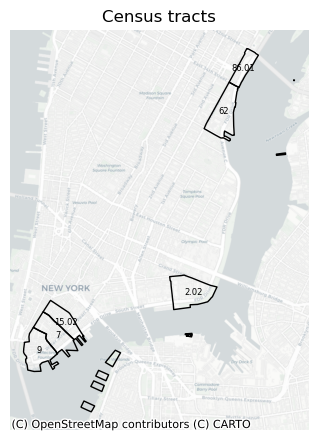

In [30]:
# -- Identify and plot these tracts --
dock_tract_ids = ["36061" + s for s in ["000900","000700","001502","000202","006200","008601"]]
dock_tracts = tracts_clean.loc[dock_tract_ids]

plotting.plot_tracts(dock_tracts)

Notice how each of these tracts contains a small amount of "land" in Brooklyn/Queens that corresponds to docks or piers, not where people actually live. We can remove these polygons from the tracts to recover the desired contiguity:

(<Figure size 600x450 with 1 Axes>, <Axes: title={'center': 'Census tracts'}>)

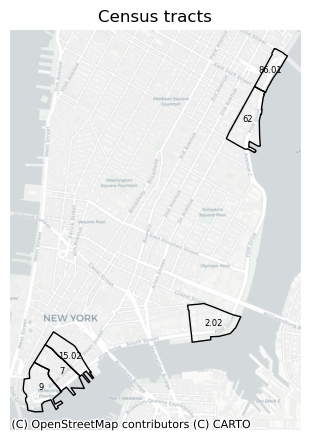

In [36]:
# -- Explode out MultiPolygons and keep only the larger chunks --
dock_tracts_clipped = dock_tracts.explode().iloc[[0,3,5,7,9,11]]

# -- Replace original tracts with clipped ones --
for id in dock_tract_ids:
    tracts_clean.loc[id] = dock_tracts_clipped.loc[id]

plotting.plot_tracts(tracts_clean.loc[dock_tract_ids])

## Save new tracts

In [37]:
# Save 2nd stage cleaning
decennial2020_dp_clean.to_parquet(config.DECENNIAL2020_DP_CLEAN)
acs5yr2023_clean.to_parquet(config.ACS5YR2023_CLEAN)
tracts_clean.to_parquet(config.TRACTS_CLEAN)